# LDM (Latent Diffusion Models) - CelebA-HQ / LSUN-Churches Training

**設定**
- Dataset: CelebA-HQ
- Resolution: 256px
- Downsample Factor: f=4 (潜在空間 64×64)
- VAE: diffusers の学習済み AutoencoderKL
- Scheduler: cosine
- wandb でログと生成画像を記録

## Environment Setup

In [1]:
!nvidia-smi

Fri Jan 30 00:56:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   36C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
os.environ['DIFFUSERS_NO_ADVISORY_WARNINGS'] = '1'
OUTPUT_DIR = './outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: ./outputs


In [3]:
!pip install -q torch torchvision torchaudio
!pip install -q diffusers transformers accelerate
!pip install -q einops tqdm scipy pillow wandb gdown
print("Package installation complete!")

Package installation complete!


In [4]:
import math
import random
import os
import json
import hashlib
from dataclasses import dataclass, field, asdict
from typing import Literal, Optional, Tuple
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import wandb
from diffusers import AutoencoderKL

from google.colab import userdata

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


@dataclass
class ModelConfig:
    image_size: int = 32
    in_channels: int = 4
    out_channels: int = 4
    model_channels: int = 128
    channel_mult: tuple = (1, 2, 3, 4)
    num_res_blocks: int = 2
    num_heads: int = 8
    use_scale_shift_norm: bool = True
    dropout: float = 0.1
    attention_resolutions: tuple = (32, 16, 8)


@dataclass
class DiffusionConfig:
    timesteps: int = 1000
    beta_schedule: Literal['linear', 'cosine', 'quadratic'] = 'cosine'
    beta_start: float = 1e-4
    beta_end: float = 0.02
    s: float = 0.008


@dataclass
class VAEConfig:
    model_id: str = 'stabilityai/sd-vae-ft-mse'
    subfolder: Optional[str] = None
    downsample_factor: int = 4
    latent_channels: int = 4
    latent_scaling_factor: float = 0.18215
    cache_dir: str = './data/latents'
    use_fp16: bool = True


@dataclass
class DataConfig:
    dataset: str = 'celebahq'
    data_dir: str = './data'
    image_size: int = 256


@dataclass
class TrainingConfig:
    batch_size: int = 64
    learning_rate: float = 2e-4
    total_steps: int = 100_000
    grad_clip: float = 1.0
    ema_decay: float = 0.9999
    save_every: int = 5000
    sample_every: int = 5000
    log_every: int = 100
    num_workers: int = 2
    mixed_precision: bool = True


@dataclass
class Config:
    model: ModelConfig = field(default_factory=ModelConfig)
    diffusion: DiffusionConfig = field(default_factory=DiffusionConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    vae: VAEConfig = field(default_factory=VAEConfig)
    data: DataConfig = field(default_factory=DataConfig)
    output_dir: str = './outputs'
    exp_name: str = 'ldm_celebahq_colab'
    seed: int = 42


def _model_config_to_dict(cfg: ModelConfig) -> dict:
    data = asdict(cfg)
    for key, value in data.items():
        if isinstance(value, tuple):
            data[key] = list(value)
    return data


config = Config()
config.model.image_size = config.data.image_size // config.vae.downsample_factor
config.model.in_channels = config.vae.latent_channels
config.model.out_channels = config.vae.latent_channels

MODEL_CONFIG_METADATA = _model_config_to_dict(config.model)
MODEL_CONFIG_SIGNATURE = hashlib.sha1(
    json.dumps(MODEL_CONFIG_METADATA, sort_keys=True).encode('utf-8')
).hexdigest()[:8]

set_seed(config.seed)
print('Config:')
print(f'  Dataset: {config.data.dataset}')
print(f'  Image size: {config.data.image_size}px')
print(f'  Downsample factor: {config.vae.downsample_factor}')
print(f'  Latent size: {config.model.image_size}x{config.model.image_size}')
print(f'  Model config signature: {MODEL_CONFIG_SIGNATURE}')


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Device: cuda
Config:
  Dataset: celebahq
  Image size: 256px
  Downsample factor: 4
  Latent size: 64x64
  Model config signature: 84b74605


In [5]:

import gdown
import zipfile
import tarfile
import shutil


def download_celebahq():
    """Resolve CelebA-HQ directory, preferring Drive cache if available."""
    drive_root = Path('/content/drive/MyDrive')
    drive_repo_candidates = [
        drive_root / 'research-experiment' / 'LDM' / 'data' / 'celeba_hq_256',
        drive_root / 'src' / 'github.com' / 'frinfo702' / 'research-experiment' / 'LDM' / 'data' / 'celeba_hq_256',
    ]
    drive_candidates = [
        drive_root / 'data' / 'LDM' / 'celeba_hq_256',
        drive_root / 'data' / 'celeba_hq_256',
        drive_root / 'celeba_hq_256',
    ]
    local_candidates = [
        Path(config.data.data_dir) / 'celeba_hq_256',
        Path('./data') / 'celeba_hq_256',
    ]

    def _count_images(p: Path) -> int:
        return len(list(p.glob('*.jpg'))) + len(list(p.glob('*.png')))

    for cand in drive_repo_candidates + drive_candidates + local_candidates:
        if cand.exists() and _count_images(cand) > 1000:
            print(f'CelebA-HQ found: {cand}')
            return cand

    local_dir = local_candidates[0]
    local_dir.mkdir(parents=True, exist_ok=True)
    print('Downloading CelebA-HQ dataset (approx 1.3GB)...')
    url = 'https://drive.google.com/uc?id=1badu11NqxGf6qM3PTTooQDJvQbejgbTv'
    output = local_dir / 'celeba_hq.zip'
    try:
        gdown.download(url, str(output), quiet=False)
        print('Extracting CelebA-HQ...')
        with zipfile.ZipFile(output, 'r') as z:
            members = z.namelist()
            for member in tqdm(members, desc='Extracting', unit='file'):
                z.extract(member, local_dir)
        output.unlink(missing_ok=True)
    except Exception as exc:  # noqa: BLE001
        print(f'Download failed: {exc}')
        print('Please manually place CelebA-HQ images under', local_dir)
    return local_dir


def download_lsun_churches():
    """Download (or locate) LSUN Churches subset."""
    data_dir = Path(config.data.data_dir) / 'lsun_churches'
    data_dir.mkdir(parents=True, exist_ok=True)
    existing_images = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.webp')) + list(data_dir.glob('*.png'))
    if len(existing_images) > 1000:
        print(f'LSUN Churches already present: {len(existing_images)} images')
        return data_dir
    print('Please place LSUN Churches images under', data_dir)
    print('Or switch to CelebA-HQ by setting config.data.dataset = "celebahq"')
    return data_dir


class ImageFolderDataset(Dataset):
    def __init__(self, data_dir: str, transform=None, extensions=('.jpg', '.jpeg', '.png', '.webp')):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.extensions = extensions
        self.image_paths = self._find_images()
        if len(self.image_paths) == 0:
            raise ValueError(f'No images found in {self.data_dir}')
        print(f'Found {len(self.image_paths)} images in {self.data_dir}')

    def _find_images(self):
        paths = []
        for ext in self.extensions:
            paths.extend(self.data_dir.rglob(f'*{ext}'))
            paths.extend(self.data_dir.rglob(f'*{ext.upper()}'))
        return sorted(paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0


def get_dataloader(dataset_name: str, image_size: int, batch_size: int, num_workers: int, train: bool = True):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip() if train else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    if dataset_name == 'celebahq':
        data_dir = download_celebahq()
    elif dataset_name == 'lsun_churches':
        data_dir = download_lsun_churches()
    else:
        raise ValueError(f'Unknown dataset: {dataset_name}')
    dataset = ImageFolderDataset(str(data_dir), transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=num_workers, drop_last=train)


def load_vae():
    dtype = torch.float16 if (config.vae.use_fp16 and DEVICE.type == 'cuda') else torch.float32
    vae = AutoencoderKL.from_pretrained(config.vae.model_id, subfolder=config.vae.subfolder)
    vae = vae.to(DEVICE, dtype=dtype).eval()
    for p in vae.parameters():
        p.requires_grad = False
    return vae


@torch.no_grad()
def prepare_latents(vae, force_recompute: bool = False):
    cache_dir = Path(config.vae.cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    safe_id = config.vae.model_id.replace('/', '_')
    cache_path = cache_dir / f"{config.data.dataset}_{config.data.image_size}_f{config.vae.downsample_factor}_{safe_id}_latents.pt"
    if cache_path.exists() and not force_recompute:
        payload = torch.load(cache_path, map_location='cpu')
        dataset = TensorDataset(payload['latents'], payload['labels'])
        print(f'Loaded cached latents: {cache_path}')
        print(f"  Shape: {payload['latents'].shape}")
        return dataset
    loader = get_dataloader(
        config.data.dataset,
        config.data.image_size,
        config.training.batch_size,
        config.training.num_workers,
        train=True,
    )
    print(f'Encoding latents for {config.data.dataset} at {config.data.image_size}px...')
    print(f'  VAE: {config.vae.model_id}')
    print(f'  Downsample factor: {config.vae.downsample_factor}')
    print(f'  Expected latent size: {config.model.image_size}x{config.model.image_size}')
    latents_list, labels_list = [], []
    for images, labels in tqdm(loader, desc='Encoding latents'):
        images = images.to(DEVICE)
        if config.vae.use_fp16 and DEVICE.type == 'cuda':
            images = images.half()
        scale = getattr(vae.config, 'scaling_factor', config.vae.latent_scaling_factor)
        dist = vae.encode(images).latent_dist
        latents = dist.sample() * scale
        latents_list.append(latents.cpu())
        labels_list.append(labels.cpu())
    latents = torch.cat(latents_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    torch.save({'latents': latents, 'labels': labels}, cache_path)
    print(f'Saved latents to: {cache_path}')
    print(f'  Shape: {latents.shape}')
    return TensorDataset(latents, labels)


vae = load_vae()
config.vae.latent_scaling_factor = getattr(vae.config, 'scaling_factor', config.vae.latent_scaling_factor)
config.vae.downsample_factor = 2 ** (len(vae.config.block_out_channels) - 1)
config.model.image_size = config.data.image_size // config.vae.downsample_factor
config.model.in_channels = vae.config.latent_channels
config.model.out_channels = vae.config.latent_channels

print(f'VAE scaling_factor: {config.vae.latent_scaling_factor}')
print(f'VAE downsample_factor: {config.vae.downsample_factor}')
print(f'Latent size: {config.model.image_size}x{config.model.image_size}')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VAE scaling_factor: 0.18215
VAE downsample_factor: 8
Latent size: 32x32


In [6]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
DATA_ROOT = Path('/content/drive/MyDrive/research-experiment/LDM/data')
OUTPUT_ROOT = Path('/content/drive/MyDrive/research-experiment/LDM/outputs')
DATA_ROOT.mkdir(parents=True, exist_ok=True)
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
config.data.data_dir = str(DATA_ROOT)
config.output_dir = str(OUTPUT_ROOT)
OUTPUT_DIR = config.output_dir
print('Data dir:', config.data.data_dir)
print('Output dir:', config.output_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data dir: /content/drive/MyDrive/research-experiment/LDM/data
Output dir: /content/drive/MyDrive/research-experiment/LDM/outputs


Checking VAE reconstruction quality...
CelebA-HQ found: /content/drive/MyDrive/research-experiment/LDM/data/celeba_hq_256
Found 30000 images in /content/drive/MyDrive/research-experiment/LDM/data/celeba_hq_256


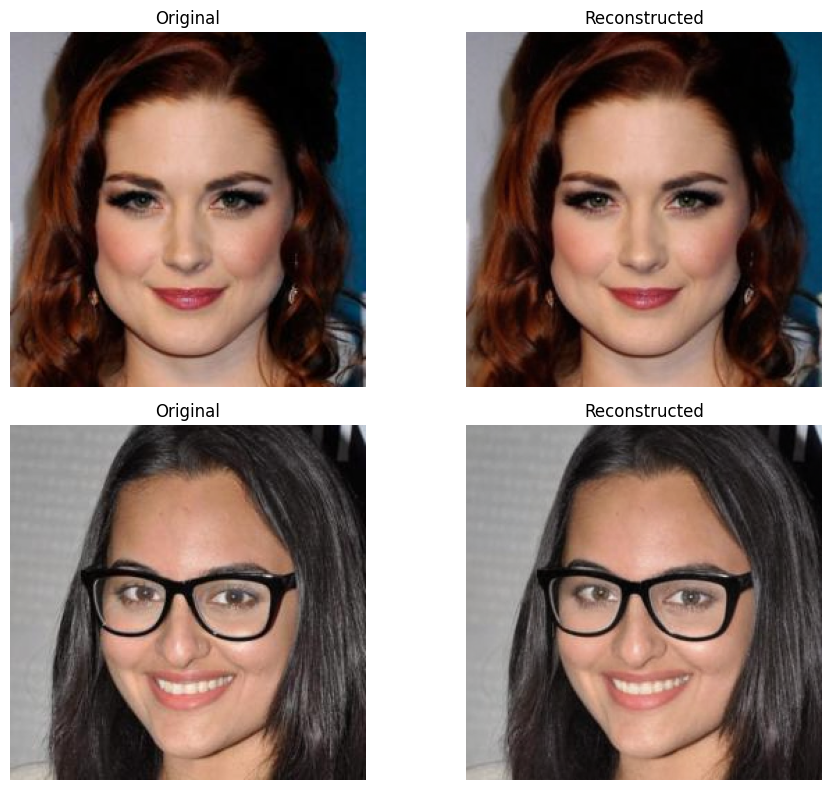

In [7]:
import matplotlib.pyplot as plt

def check_vae_reconstruction(vae, batch_size=2):
    check_loader = get_dataloader(
        config.data.dataset,
        config.data.image_size,
        batch_size,
        num_workers=1,
        train=True
    )

    images, _ = next(iter(check_loader))
    images = images.to(DEVICE)
    if config.vae.use_fp16 and DEVICE.type == 'cuda':
        images = images.half()

    with torch.no_grad():
        dist = vae.encode(images).latent_dist
        latents = dist.sample()

        recons = vae.decode(latents).sample

    images = (images.float() * 0.5 + 0.5).clamp(0, 1).cpu()
    recons = (recons.float() * 0.5 + 0.5).clamp(0, 1).cpu()

    fig, axes = plt.subplots(batch_size, 2, figsize=(10, 4 * batch_size))
    if batch_size == 1: axes = [axes]

    for i in range(batch_size):
        ax_orig = axes[i][0] if batch_size > 1 else axes[0]
        ax_recon = axes[i][1] if batch_size > 1 else axes[1]

        ax_orig.imshow(images[i].permute(1, 2, 0))
        ax_orig.set_title("Original")
        ax_orig.axis('off')

        ax_recon.imshow(recons[i].permute(1, 2, 0))
        ax_recon.set_title("Reconstructed")
        ax_recon.axis('off')

    plt.tight_layout()
    plt.show()

print("Checking VAE reconstruction quality...")
check_vae_reconstruction(vae, batch_size=2)


In [8]:
latent_dataset = prepare_latents(vae, force_recompute=False)
latent_loader = DataLoader(latent_dataset, batch_size=config.training.batch_size, shuffle=True, num_workers=config.training.num_workers, drop_last=True)
print(f'Latent batches: {len(latent_loader)}')

Loaded cached latents: data/latents/celebahq_256_f8_stabilityai_sd-vae-ft-mse_latents.pt
  Shape: torch.Size([29952, 4, 32, 32])
Latent batches: 468


In [9]:

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
    def forward(self, time: torch.Tensor) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Swish(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * torch.sigmoid(x)

class GroupNorm32(nn.GroupNorm):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return super().forward(x.float()).type(x.dtype)

def normalization(channels: int, num_groups: int = 32) -> nn.Module:
    return GroupNorm32(min(num_groups, channels), channels)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1, use_scale_shift_norm=True):
        super().__init__()
        self.use_scale_shift_norm = use_scale_shift_norm
        self.norm1 = normalization(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm2 = normalization(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        time_out_dim = out_channels * 2 if use_scale_shift_norm else out_channels
        self.time_mlp = nn.Sequential(Swish(), nn.Linear(time_emb_dim, time_out_dim))
        self.dropout = nn.Dropout(dropout)
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    def forward(self, x, time_emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        time_emb = self.time_mlp(time_emb)
        time_emb = time_emb[:, :, None, None]
        if self.use_scale_shift_norm:
            scale, shift = time_emb.chunk(2, dim=1)
            h = self.norm2(h) * (1 + scale) + shift
        else:
            h = h + time_emb
            h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)
        return h + self.skip(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels: int, num_heads: int = 4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.norm = normalization(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = self.head_dim ** -0.5
    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        qkv = self.qkv(x_norm)
        qkv = qkv.reshape(b, 3, self.num_heads, self.head_dim, h * w)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]
        q = q.permute(0, 1, 3, 2)
        k = k.permute(0, 1, 3, 2)
        v = v.permute(0, 1, 3, 2)
        attn = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = attn.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = out.permute(0, 1, 3, 2).reshape(b, c, h, w)
        out = self.proj(out)
        return x + out

class Downsample(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.image_size = cfg.image_size
        time_emb_dim = cfg.model_channels * 4
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(cfg.model_channels),
            nn.Linear(cfg.model_channels, time_emb_dim),
            Swish(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        self.init_conv = nn.Conv2d(cfg.in_channels, cfg.model_channels, 3, padding=1)

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        channels = [cfg.model_channels]
        ch = cfg.model_channels
        resolution = cfg.image_size

        for level, mult in enumerate(cfg.channel_mult):
            out_ch = cfg.model_channels * mult
            for _ in range(cfg.num_res_blocks):
                layers = [ResidualBlock(ch, out_ch, time_emb_dim, cfg.dropout, cfg.use_scale_shift_norm)]
                ch = out_ch
                if resolution in cfg.attention_resolutions:
                    layers.append(AttentionBlock(ch, cfg.num_heads))
                self.downs.append(nn.ModuleList(layers))
                channels.append(ch)
            if level != len(cfg.channel_mult) - 1:
                self.downs.append(nn.ModuleList([Downsample(ch)]))
                channels.append(ch)
                resolution //= 2

        self.mid = nn.ModuleList([
            ResidualBlock(ch, ch, time_emb_dim, cfg.dropout, cfg.use_scale_shift_norm),
            AttentionBlock(ch, cfg.num_heads),
            ResidualBlock(ch, ch, time_emb_dim, cfg.dropout, cfg.use_scale_shift_norm),
        ])

        for level, mult in enumerate(reversed(cfg.channel_mult)):
            out_ch = cfg.model_channels * mult
            for i in range(cfg.num_res_blocks + 1):
                skip_ch = channels.pop()
                layers = [ResidualBlock(ch + skip_ch, out_ch, time_emb_dim, cfg.dropout, cfg.use_scale_shift_norm)]
                ch = out_ch
                if resolution in cfg.attention_resolutions:
                    layers.append(AttentionBlock(ch, cfg.num_heads))
                if level != len(cfg.channel_mult) - 1 and i == cfg.num_res_blocks:
                    layers.append(Upsample(ch))
                    resolution *= 2
                self.ups.append(nn.ModuleList(layers))

        self.final_norm = normalization(ch)
        self.final_conv = nn.Conv2d(ch, cfg.out_channels, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        h = self.init_conv(x)
        hs = [h]
        for layers in self.downs:
            for layer in layers:
                if isinstance(layer, ResidualBlock):
                    h = layer(h, t_emb)
                else:
                    h = layer(h)
            hs.append(h)
        for layer in self.mid:
            if isinstance(layer, ResidualBlock):
                h = layer(h, t_emb)
            else:
                h = layer(h)
        for layers in self.ups:
            h = torch.cat([h, hs.pop()], dim=1)
            for layer in layers:
                if isinstance(layer, ResidualBlock):
                    h = layer(h, t_emb)
                else:
                    h = layer(h)
        h = self.final_norm(h)
        h = F.silu(h)
        return self.final_conv(h)


## Diffusion + EMA

In [10]:

def cosine_beta_schedule(timesteps: int, s: float = 0.008) -> torch.Tensor:
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)

class GaussianDiffusion(nn.Module):
    def __init__(self, model, cfg: DiffusionConfig):
        super().__init__()
        self.model = model
        self.timesteps = cfg.timesteps
        betas = cosine_beta_schedule(cfg.timesteps, cfg.s)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod - 1))
        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.register_buffer('posterior_variance', posterior_variance)
        self.register_buffer('posterior_log_variance_clipped', torch.log(torch.clamp(posterior_variance, min=1e-20)))
        self.register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod))
        self.register_buffer('posterior_mean_coef2', (1.0 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - alphas_cumprod))

    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise

    def predict_start_from_noise(self, x_t, t, noise):
        sqrt_recip = self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape)
        sqrt_recipm1 = self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        return sqrt_recip * x_t - sqrt_recipm1 * noise

    def q_posterior(self, x_0, x_t, t):
        mean = self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_0 + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        log_var = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return mean, log_var

    def p_mean_variance(self, x_t, t):
        predicted_noise = self.model(x_t, t)
        x_0_pred = self.predict_start_from_noise(x_t, t, predicted_noise)
        x_0_pred = torch.clamp(x_0_pred, -1.0, 1.0)
        model_mean, model_log_variance = self.q_posterior(x_0_pred, x_t, t)
        return model_mean, model_log_variance

    @torch.no_grad()
    def p_sample(self, x_t, t):
        model_mean, model_log_variance = self.p_mean_variance(x_t, t)
        noise = torch.randn_like(x_t)
        nonzero_mask = (t != 0).float().reshape(-1, *((1,) * (len(x_t.shape) - 1)))
        return model_mean + nonzero_mask * torch.exp(0.5 * model_log_variance) * noise

    @torch.no_grad()
    def sample(self, batch_size, image_size, channels, progress=True):
        device = self.betas.device
        x = torch.randn((batch_size, channels, image_size, image_size), device=device)
        timesteps = list(reversed(range(self.timesteps)))
        if progress:
            timesteps = tqdm(timesteps, desc='Sampling', leave=False)
        for t in timesteps:
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = self.p_sample(x, t_batch)
        return x

    def compute_loss(self, x_0):
        b = x_0.shape[0]
        t = torch.randint(0, self.timesteps, (b,), device=x_0.device, dtype=torch.long)
        noise = torch.randn_like(x_0)
        x_t, _ = self.q_sample(x_0, t, noise)
        predicted_noise = self.model(x_t, t)
        return F.mse_loss(predicted_noise, noise)


In [11]:

class EMA:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    def update(self, model):
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            self.shadow[name] = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
    def apply_to(self, model):
        for name, param in model.named_parameters():
            if name in self.shadow:
                param.data.copy_(self.shadow[name])
    def state_dict(self):
        return {'decay': self.decay, 'shadow': self.shadow}
    def load_state_dict(self, state):
        if not state:
            return
        self.decay = state.get('decay', self.decay)
        self.shadow = state.get('shadow', self.shadow)


## Training

In [12]:

model = UNet(config.model).to(DEVICE)
diffusion = GaussianDiffusion(model, config.diffusion).to(DEVICE)
ema = EMA(model, decay=config.training.ema_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.training.learning_rate)
scaler = GradScaler() if (config.training.mixed_precision and DEVICE.type == 'cuda') else None

total_steps = max(1, config.training.total_steps)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=total_steps,
    eta_min=2e-4,
)

num_params = sum(p.numel() for p in model.parameters())
print(f'Model parameters: {num_params:,}')

OUTPUT_DIR = config.output_dir
CHECKPOINT_DIR = Path(config.output_dir) / 'checkpoints' / MODEL_CONFIG_SIGNATURE
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Checkpoint directory: {CHECKPOINT_DIR}')

def _summarize_keys(keys):
    if not keys:
        return 'none'
    preview = ', '.join(keys[:5])
    remaining = len(keys) - 5
    if remaining > 0:
        preview += f' (+{remaining} more)'
    return preview

def decode_latents(latents):
    scale = getattr(vae.config, 'scaling_factor', config.vae.latent_scaling_factor)
    latents = latents / scale
    latents = latents.to(dtype=vae.dtype)
    images = vae.decode(latents).sample
    images = (images + 1) / 2
    return images.clamp(0, 1)

@torch.no_grad()
def vae_sanity_check(n: int = 8, out_path: str = None):
    # VAE-only reconstruction to verify normalization and scaling
    loader = get_dataloader(
        config.data.dataset,
        config.data.image_size,
        batch_size=n,
        num_workers=config.training.num_workers,
        train=False,
    )
    images, _ = next(iter(loader))
    images = images.to(DEVICE)
    if config.vae.use_fp16 and DEVICE.type == 'cuda':
        images = images.half()

    dist = vae.encode(images).latent_dist
    latents = dist.sample()
    if latents.shape[-1] != config.model.image_size:
        print(
            f'WARNING: latent size {latents.shape[-1]} != expected {config.model.image_size}'
        )

    scale = getattr(vae.config, 'scaling_factor', config.vae.latent_scaling_factor)
    latents_scaled = latents * scale
    recon = decode_latents(latents_scaled)

    images_vis = (images + 1) / 2
    images_vis = images_vis.clamp(0, 1)

    grid = torch.cat([images_vis, recon], dim=0)
    grid = torchvision.utils.make_grid(grid, nrow=n, padding=2)
    if out_path is None:
        out_path = str(Path(OUTPUT_DIR) / 'vae_recon.png')
    torchvision.utils.save_image(grid, out_path)
    print(f'Saved VAE sanity check: {out_path}')

def log_samples(step):
    model.eval()
    with torch.no_grad():
        latents = diffusion.sample(64, config.model.image_size, config.model.out_channels, progress=False)
        images = decode_latents(latents)
    grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
    save_path = Path(OUTPUT_DIR) / f'samples_{step:08d}.png'
    torchvision.utils.save_image(grid, save_path)
    if wandb.run is not None:
        wandb.log({'samples': wandb.Image(grid), 'step': step})
    model.train()

def _checkpoint_state(step, running_loss):
    return {
        'model': model.state_dict(),
        'ema': ema.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'scaler': scaler.state_dict() if scaler is not None else None,
        'step': step,
        'running_loss': running_loss,
        'model_config_signature': MODEL_CONFIG_SIGNATURE,
        'model_config': MODEL_CONFIG_METADATA,
    }

def save_checkpoint(step, running_loss):
    state = _checkpoint_state(step, running_loss)
    ckpt_path = CHECKPOINT_DIR / f'ckpt_{step:08d}.pt'
    torch.save(state, ckpt_path)
    torch.save(state, CHECKPOINT_DIR / 'latest.pt')
    print(f'Saved checkpoint: {ckpt_path}')

def find_latest_checkpoint():
    latest = CHECKPOINT_DIR / 'latest.pt'
    if latest.exists():
        return latest
    candidates = sorted(CHECKPOINT_DIR.glob('ckpt_*.pt'))
    return candidates[-1] if candidates else None

def load_checkpoint(path):
    state = torch.load(path, map_location=DEVICE)
    ckpt_sig = state.get('model_config_signature')
    if ckpt_sig is not None and ckpt_sig != MODEL_CONFIG_SIGNATURE:
        print(
            'Skipping checkpoint with mismatched model signature '
            f"(found {ckpt_sig}, expected {MODEL_CONFIG_SIGNATURE})."
        )
        return 0, 0.0
    model_keys = set(model.state_dict().keys())
    ckpt_keys = set(state['model'].keys())
    missing = sorted(model_keys - ckpt_keys)
    unexpected = sorted(ckpt_keys - model_keys)
    if missing or unexpected:
        print('Skipping checkpoint because parameter shapes changed:')
        print(f'  Missing keys: {_summarize_keys(missing)}')
        print(f'  Unexpected keys: {_summarize_keys(unexpected)}')
        print('Delete the incompatible checkpoint directory if you intended to restart.')
        return 0, 0.0
    step = int(state.get('step', 0))
    running_loss = float(state.get('running_loss', 0.0))
    model.load_state_dict(state['model'])
    ema.load_state_dict(state.get('ema', {}))
    optimizer.load_state_dict(state['optimizer'])
    if state.get('scheduler') is not None:
        scheduler.load_state_dict(state['scheduler'])
    else:
        scheduler.last_epoch = step - 1
    if scaler is not None and state.get('scaler') is not None:
        scaler.load_state_dict(state['scaler'])
    print(f'Resumed from checkpoint: {path} (step={step})')
    return step, running_loss

WANDB_API_KEY = userdata.get('WANDB_API_KEY')
if WANDB_API_KEY:
    wandb.login(key=WANDB_API_KEY)

wandb.init(project=f'ldm-{config.data.dataset}', name=config.exp_name, config={
    'dataset': config.data.dataset,
    'timesteps': config.diffusion.timesteps,
    'beta_schedule': config.diffusion.beta_schedule,
    'batch_size': config.training.batch_size,
    'lr': config.training.learning_rate,
    'image_size': config.data.image_size,
    'latent_size': config.model.image_size,
    'downsample_factor': config.vae.downsample_factor,
    'model_params': num_params,
    'model_signature': MODEL_CONFIG_SIGNATURE,
})

step = 0
running_loss = 0.0
latest_ckpt = find_latest_checkpoint()
if latest_ckpt is not None:
    step, running_loss = load_checkpoint(latest_ckpt)

pbar = tqdm(total=config.training.total_steps, initial=step, desc='Training')

while step < config.training.total_steps:
    for batch in latent_loader:
        if step >= config.training.total_steps:
            break
        latents = batch[0].to(DEVICE)
        optimizer.zero_grad()
        if scaler is not None:
            with autocast():
                loss = diffusion.compute_loss(latents)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            loss = diffusion.compute_loss(latents)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.grad_clip)
            optimizer.step()
            scheduler.step()
        ema.update(model)
        step += 1
        running_loss += loss.item()
        if step % config.training.log_every == 0:
            avg_loss = running_loss / config.training.log_every
            lr = scheduler.get_last_lr()[0]
            wandb.log({'loss': avg_loss, 'lr': lr, 'step': step})
            pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'lr': f'{lr:.6f}'})
            running_loss = 0.0
        if step % config.training.sample_every == 0:
            log_samples(step)
        if step % config.training.save_every == 0:
            save_checkpoint(step, running_loss)
        pbar.update(1)

pbar.close()
save_checkpoint(step, running_loss)
wandb.finish()
print('Training done.')


/tmp/ipython-input-4282849569.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if (config.training.mixed_precision and DEVICE.type == 'cuda') else None


Model parameters: 88,419,716
Checkpoint directory: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: is0724rp (is0724rp-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training:   0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipython-input-4282849569.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:   5%|▌         | 5000/100000 [18:48<883:14:41, 33.47s/it, loss=0.2583, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00005000.pt


Training:  10%|█         | 10000/100000 [37:35<833:16:15, 33.33s/it, loss=0.2483, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00010000.pt


Training:  15%|█▌        | 15000/100000 [56:26<783:31:27, 33.18s/it, loss=0.2518, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00015000.pt


Training:  20%|██        | 20000/100000 [1:15:13<738:48:59, 33.25s/it, loss=0.2487, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00020000.pt


Training:  25%|██▌       | 25000/100000 [1:34:02<695:50:03, 33.40s/it, loss=0.2474, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00025000.pt


Training:  30%|███       | 30000/100000 [1:52:50<645:24:15, 33.19s/it, loss=0.2452, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00030000.pt


Training:  35%|███▌      | 35000/100000 [2:11:37<599:23:45, 33.20s/it, loss=0.2417, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00035000.pt


Training:  40%|████      | 40000/100000 [2:30:27<554:35:28, 33.28s/it, loss=0.2405, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00040000.pt


Training:  45%|████▌     | 45000/100000 [2:49:14<508:19:53, 33.27s/it, loss=0.2447, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00045000.pt


Training:  50%|█████     | 50000/100000 [3:08:04<463:42:30, 33.39s/it, loss=0.2405, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00050000.pt


Training:  55%|█████▌    | 55000/100000 [3:26:53<416:51:03, 33.35s/it, loss=0.2448, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00055000.pt


Training:  60%|██████    | 60000/100000 [3:45:40<371:15:06, 33.41s/it, loss=0.2421, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00060000.pt


Training:  65%|██████▌   | 65000/100000 [4:04:28<326:11:50, 33.55s/it, loss=0.2413, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00065000.pt


Training:  70%|███████   | 70000/100000 [4:23:13<279:35:39, 33.55s/it, loss=0.2396, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00070000.pt


Training:  75%|███████▌  | 75000/100000 [4:42:01<230:52:56, 33.25s/it, loss=0.2355, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00075000.pt


Training:  80%|████████  | 80000/100000 [5:00:45<184:16:07, 33.17s/it, loss=0.2418, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00080000.pt


Training:  85%|████████▌ | 85000/100000 [5:19:32<137:57:59, 33.11s/it, loss=0.2419, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00085000.pt


Training:  90%|█████████ | 90000/100000 [5:38:13<92:11:10, 33.19s/it, loss=0.2376, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00090000.pt


Training:  95%|█████████▌| 95000/100000 [5:56:55<46:08:34, 33.22s/it, loss=0.2419, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00095000.pt


Training: 100%|██████████| 100000/100000 [6:15:37<00:00,  4.44it/s, loss=0.2421, lr=0.000200]

Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00100000.pt


Saved checkpoint: /content/drive/MyDrive/research-experiment/LDM/outputs/checkpoints/84b74605/ckpt_00100000.pt


loss,█▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▂▂▁▂▃▂▂▁▂▂▂▁▁▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
loss,0.24206
lr,0.0002
step,100000


Training done.
